In [254]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import *
from keras.losses import categorical_crossentropy
import keras.backend as K
from sudoku import Sudoku
from dataset import SudokuDataset
from itertools import *
from functools import partial
from operator import itemgetter

%matplotlib inline

In [259]:
def samples():
    it = SudokuDataset().get_samples(return_solutions=True)
    while True:
        yield tuple(map(partial(to_categorical, num_classes=10),\
                        map(lambda sudoku: sudoku.values.flatten(), next(it))))
        
def batches(batch_size=1):
    it = samples()
    while True:
        X_batch, y_batch = tuple([np.zeros([batch_size, 81, 10]) for i in range(0, 2)])
        for k in range(0, batch_size):
            X_batch[k], y_batch[k] = next(it)
        yield X_batch, y_batch

        
def show_batch(batch_size=4):
    X_batch, y_batch = next(batches(batch_size))
    plt.figure(figsize=(8, batch_size * 4))
    for k in range(0, batch_size):
        unsolved, solved = tuple(
            map(Sudoku,
                map(partial(np.argmax, axis=1),
                    map(itemgetter(k), (X_batch, y_batch))))
        )
        
        plt.subplot(batch_size, 2, 2*k+1)
        unsolved.draw()
        
        plt.subplot(batch_size, 2, 2*(k+1))
        solved.draw()

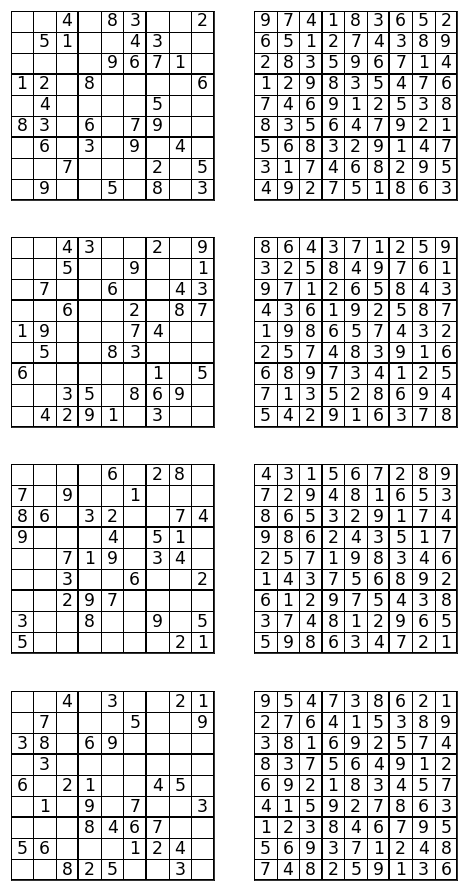

In [260]:
show_batch()

In [306]:
def loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred)

In [307]:
t_in = Input((81, 10), dtype='float32')
x = t_in
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
t_soft =  Dense(10, activation='softmax')(x)

t_out = t_soft
model = Model([t_in], [t_out])
model.summary()
model.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        (None, 81, 10)            0         
_________________________________________________________________
dense_219 (Dense)            (None, 81, 256)           2816      
_________________________________________________________________
dense_220 (Dense)            (None, 81, 256)           65792     
_________________________________________________________________
dense_221 (Dense)            (None, 81, 256)           65792     
_________________________________________________________________
dense_222 (Dense)            (None, 81, 10)            2570      
Total params: 136,970
Trainable params: 136,970
Non-trainable params: 0
_________________________________________________________________


In [308]:
model.fit_generator(batches(), epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 15s 148ms/step - loss: 1.3700 - acc: 0.4789
Epoch 2/3
100/100 [==============================] - 12s 116ms/step - loss: 1.2858 - acc: 0.482710s - - ETA: 2s - loss: 1.2863 - acc: 0.483 - ETA: 2s - loss: 1.2861  - ETA: 0s - loss: 1.2853 - acc: 0.4
Epoch 3/3
100/100 [==============================] - 12s 116ms/step - loss: 1.2866 - acc: 0.4811


In [295]:
def predict(X, *args, **kwargs):
    y_pred = model.predict(X, *args, **kwargs)
    a = np.expand_dims(X[:, :, 0], axis=2)
    y_pred = a * y_pred + (1 - a) * X
    return y_pred

def show_predict(batch_size=4, *args, **kwargs):
    X, y = next(batches(batch_size=batch_size))
    y_pred = predict(X)
    
    plt.figure(figsize=(12, 4*batch_size))
    for k in range(0, batch_size):
        unsolved, solved, output =\
            tuple(map(Sudoku,
                      map(partial(np.argmax, axis=1),
                          map(itemgetter(k), (X, y, y_pred)))))
        plt.subplot(batch_size, 3, k*3+1)
        unsolved.draw()
        
        plt.subplot(batch_size, 3, k*3+2)
        solved.draw()
        
        plt.subplot(batch_size, 3, (k+1)*3)
        output.draw()

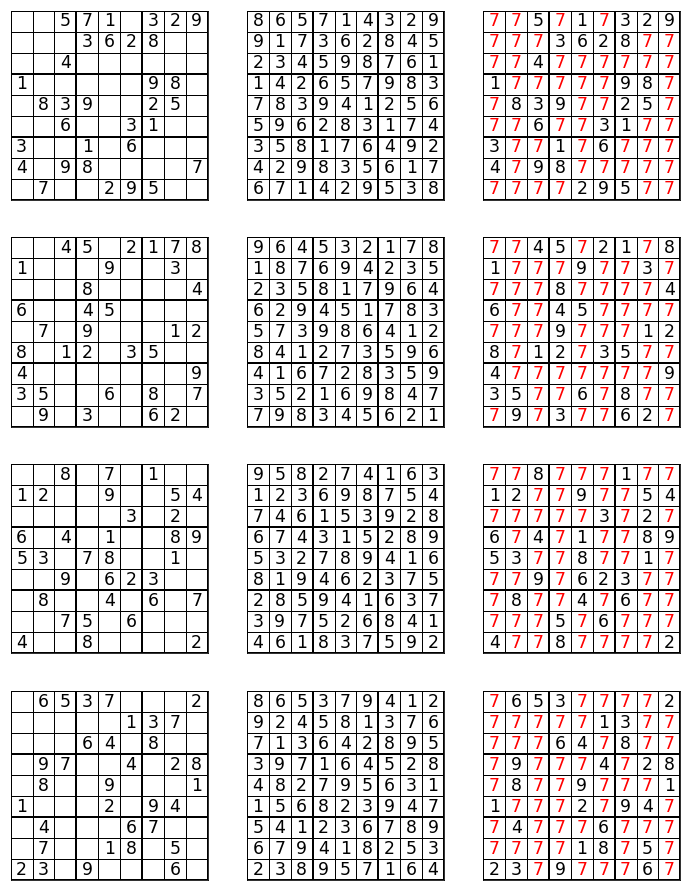

In [309]:
show_predict()